# SARCASM DETECTION `

### Author: Bobby Tomlinson
### RedID: 827052376

#### Library Imports

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from urllib.parse import urlparse
from joblib import dump, load
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [12]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bobbytomlinson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bobbytomlinson/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bobbytomlinson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Data Import

In [3]:
# # This code was ran once, and is now inactive
# # Converts and exports original JSON data from Kaggle into CSV
# json_file_path = 'data/Sarcasm_Headlines_Dataset_v2.json'

# json_df = pd.read_json(json_file_path, lines=True) 

# csv_file_path = 'data/sarcasmHeadlinesData.csv'

# json_df.to_csv(csv_file_path, index=False)

In [13]:
sarcasm_data_path = 'data/sarcasmHeadlinesData.csv'
df = pd.read_csv(sarcasm_data_path)

print(df.head())

   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  


#### Exploratory Data Analysis

In [14]:
# Basic Data Statistics

print(df.info())

print()

print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB
None

        is_sarcastic                                           headline  \
count   28619.000000                                              28619   
unique           NaN                                              28503   
top              NaN  'no way to prevent this,' says only nation whe...   
freq             NaN                                                 12   
mean        0.476397                                                NaN   
std         0.499451                                                NaN   
min         0.000000                                                NaN   
25%         0.000000    

Upon first look, this appears to be normally distributed - I will create a visualization later just to make sure.

In [15]:
# Checking for missing values
print(df.isnull().sum())

is_sarcastic    0
headline        0
article_link    0
dtype: int64


In [16]:
# Removing All Potential Duplicate Headlines from the Dataset

df = df.drop_duplicates(subset='headline')

No data cleaning or imputation necessary! This is great news

In [17]:
sarcasm_counts = df['is_sarcastic'].value_counts()
print(sarcasm_counts)

is_sarcastic
0    14951
1    13552
Name: count, dtype: int64


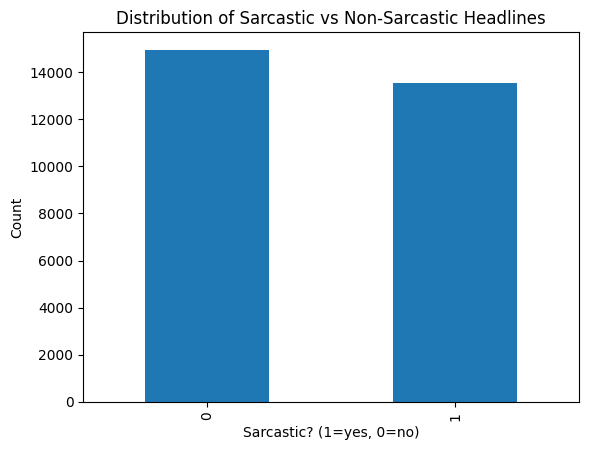

In [18]:
sarcasm_counts.plot(kind='bar')
plt.title('Distribution of Sarcastic vs Non-Sarcastic Headlines')
plt.xlabel('Sarcastic? (1=yes, 0=no)')
plt.ylabel('Count')
plt.show()

This looks very balanced! No skew to be concerned about.

Only 1 unique publication(s) found with sarcastic headlines.
Top Publications with the Highest Count of Sarcastic Headlines:
publication
theonion.com    13552
Name: count, dtype: int64


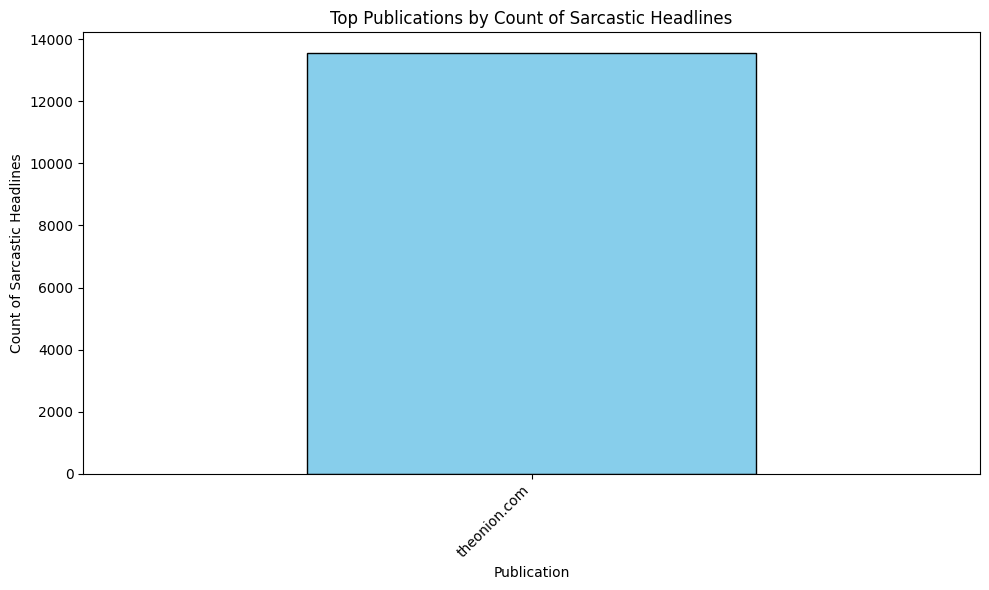

In [19]:
def get_base_domain(link):
    if pd.isnull(link):
        return 'unknown'
    domain = urlparse(link).netloc
    parts = domain.split('.')
    # If domain has more than two parts, join the last two (e.g., "politics.theonion.com" -> "theonion.com")
    if len(parts) > 2:
        return '.'.join(parts[-2:])
    return domain

# Apply the base domain extraction function
df['publication'] = df['article_link'].apply(get_base_domain)

# Filter the DataFrame to only include sarcastic headlines
sarcastic_df = df[df['is_sarcastic'] == 1]

# Count the number of sarcastic headlines per base publication
publication_counts = sarcastic_df['publication'].value_counts()

# Determine how many publications are available
num_publications = len(publication_counts)

if num_publications == 0:
    print("No sarcastic headlines found.")
elif num_publications < 5:
    print(f"Only {num_publications} unique publication(s) found with sarcastic headlines.")
    top_publications = publication_counts.head(num_publications)
else:
    top_publications = publication_counts.head(5)

print("Top Publications with the Highest Count of Sarcastic Headlines:")
print(top_publications)

# Visualize the top publications
plt.figure(figsize=(10, 6))
top_publications.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top Publications by Count of Sarcastic Headlines')
plt.xlabel('Publication')
plt.ylabel('Count of Sarcastic Headlines')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

count    28503.000000
mean        62.380241
std         20.706474
min          7.000000
25%         49.000000
50%         62.000000
75%         75.000000
max        926.000000
Name: headline_length, dtype: float64



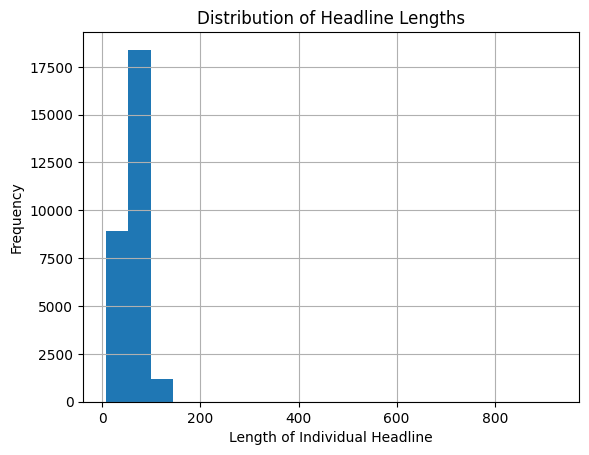

In [20]:
# Analyzing Headline Text Length
df['headline_length'] = df['headline'].apply(len)

print(df['headline_length'].describe())

print()

df['headline_length'].hist(bins=20)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Length of Individual Headline')
plt.ylabel('Frequency')
plt.show()

Seem to be some outliers on the far right side of the curve. 3rd quartile is 75, but the max is 926!

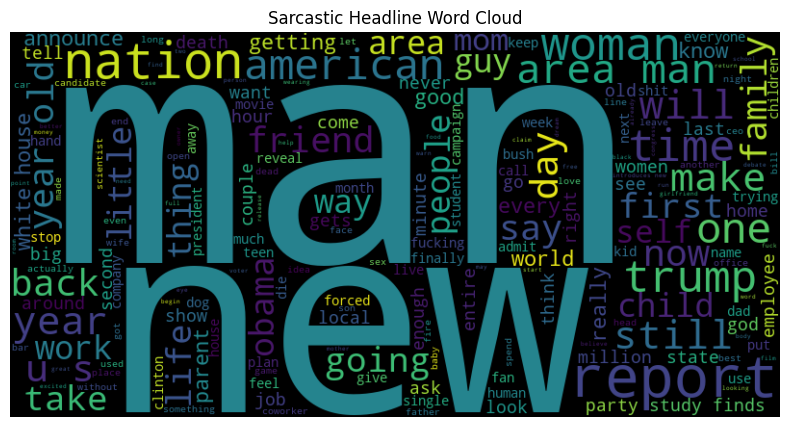

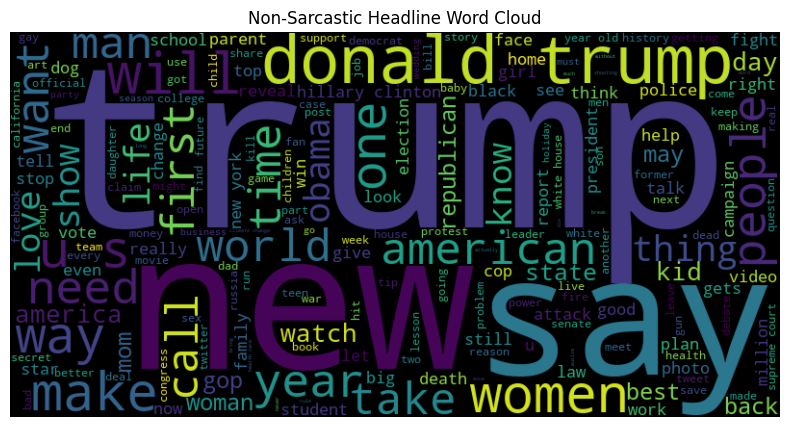

In [21]:
# Word Frequency Analysis

# Separating headlines depending on whether they are sarcastic or not
sarcastic_headlines = df[df['is_sarcastic'] == 1]['headline']
non_sarcastic_headlines = df[df['is_sarcastic'] == 0]['headline']

# Creating word clouds for each
sarcastic_text = " ".join(sarcastic_headlines)
non_sarcastic_text = " ".join(non_sarcastic_headlines)

sarcastic_wordcloud = WordCloud(width=800, height=400).generate(sarcastic_text)
non_sarcastic_wordcloud = WordCloud(width=800, height=400).generate(non_sarcastic_text)

# Plotting the created word clouds
plt.figure(figsize=(10, 5))
plt.imshow(sarcastic_wordcloud, interpolation='bilinear')
plt.title('Sarcastic Headline Word Cloud')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(non_sarcastic_wordcloud, interpolation='bilinear')
plt.title('Non-Sarcastic Headline Word Cloud')
plt.axis('off')
plt.show()

In [12]:
# Attempting to explore common bigrams and trigrams in sarcastic and non-sarcastic headlines

def get_top_ngrams(corpus, n, top_n):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

print("For Sarcastic Headlines:")
print("Top 10 Bigrams:", get_top_ngrams(sarcastic_headlines, 2, 10))
print("Top 10 Trigrams:", get_top_ngrams(sarcastic_headlines, 3, 10))


print()
print("For Non-Sarcastic Headlines:")
print("Top 10 Bigrams:", get_top_ngrams(non_sarcastic_headlines, 2, 10))
print("Top 10 Trigrams:", get_top_ngrams(non_sarcastic_headlines, 3, 10))


For Sarcastic Headlines:
Top 10 Bigrams: [('area man', np.int64(260)), ('out of', np.int64(208)), ('to be', np.int64(192)), ('year old', np.int64(188)), ('to get', np.int64(131)), ('white house', np.int64(127)), ('study finds', np.int64(123)), ('going to', np.int64(115)), ('of the', np.int64(88)), ('forced to', np.int64(80))]
Top 10 Trigrams: [('new study finds', np.int64(35)), ('in front of', np.int64(25)), ('game of thrones', np.int64(23)), ('state of the', np.int64(22)), ('of the union', np.int64(22)), ('new line of', np.int64(22)), ('announces plans to', np.int64(21)), ('majority of americans', np.int64(19)), ('in middle of', np.int64(18)), ('for first time', np.int64(17))]

For Non-Sarcastic Headlines:
Top 10 Bigrams: [('donald trump', np.int64(447)), ('in the', np.int64(308)), ('of the', np.int64(280)), ('how to', np.int64(203)), ('to the', np.int64(164)), ('to be', np.int64(163)), ('on the', np.int64(158)), ('and the', np.int64(146)), ('hillary clinton', np.int64(140)), ('for th

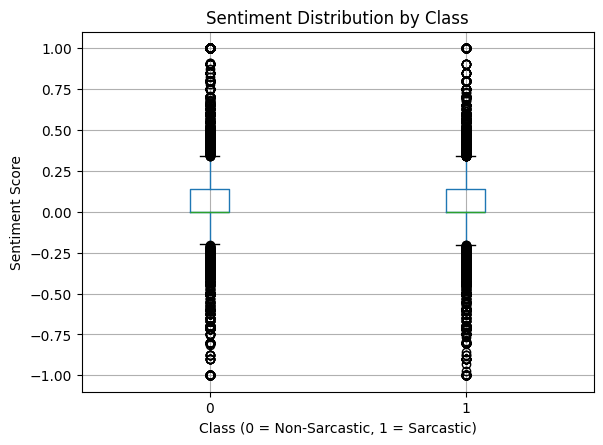

In [13]:
# Looking into potential relationship between Inferred Sentiment and Sarcasm
df['sentiment'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting Sentiment Distribution
df.boxplot(column='sentiment', by='is_sarcastic')
plt.title('Sentiment Distribution by Class')
plt.suptitle('')
plt.xlabel('Class (0 = Non-Sarcastic, 1 = Sarcastic)')
plt.ylabel('Sentiment Score')
plt.show()

Very similar sentiment distributions for both types of headlines, centered around neutral sentiment! Intuitively, this makes sense. Sarcasm can be both positive or negative.

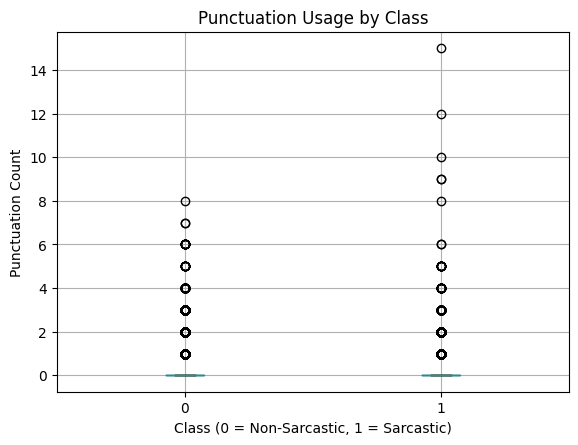

In [14]:
# Analyzing Presence of Punctuation and Special Characters in Headlines

df['punctuation_count'] = df['headline'].apply(lambda x: sum([1 for char in x if char in '!?.,"']))

# Plotting the Usage of Punctuation for Sarcastic and Non-Sarcastic Headlines
df.boxplot(column='punctuation_count', by='is_sarcastic')
plt.title('Punctuation Usage by Class')
plt.suptitle('')
plt.xlabel('Class (0 = Non-Sarcastic, 1 = Sarcastic)')
plt.ylabel('Punctuation Count')
plt.show()

#### Pre-Processing

In [15]:
def preprocess_headline(text):
    # First, the headline is lowercased
    text = text.lower()

    # Next, the headline is tokenized
    tokens = word_tokenize(text)

    # Punctuation is now removed
    tokens = [word for word in tokens if word.isalnum()]

    # Now, the headline is lemmatized
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Last, stop words are removed
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    
    # The pre-processed sequence of tokens is now returned (lowercased, lemmatized, with stop words and punctuation removed)
    return ' '.join(tokens)

# Preprocessing and cleaning up the headline feature
df['headline'] = df['headline'].apply(preprocess_headline)

# Splitting text feature from target labels
X = df['headline']
y = df['is_sarcastic']



In [16]:
# TF-IDF vectorizing the headlines
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, # No more than 5000 features(words)
    ngram_range=(1, 2) # Will utilize unigrams and bigrams
)

X_tfidf = tfidf_vectorizer.fit_transform(X)

print("Shape of TF-IDF Feature Matrix: ", X_tfidf.shape)

Shape of TF-IDF Feature Matrix:  (28503, 5000)


In [17]:
# Completing a train-test-split of features and labels
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Converting feature sets to dense format for GaussianNB
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

#### Model Implementations

In [18]:
# Model Results Storage
model_results = []

##### Logistic Regression

In [19]:
# Hyperparameter candidates for Logistic Regression Model
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

# GridSearch Hyperparameter tuning
grid_lr = GridSearchCV(LogisticRegression(
    max_iter=1000,
    random_state=42),
    param_grid_lr,
    cv=3,
    scoring='accuracy'
)

# Fitting and tuning logistic regression model
grid_lr.fit(X_train, y_train)
lr_model = grid_lr.best_estimator_

# Computing predictions with trained and tuned model
y_pred_lr = lr_model.predict(X_test)
model_results.append(('Logistic Regression',
                      accuracy_score(y_test, y_pred_lr)))

print("Logistic Regression Optimal Parameters: ", grid_lr.best_params_)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Optimal Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      3048
           1       0.79      0.74      0.76      2653

    accuracy                           0.79      5701
   macro avg       0.79      0.78      0.78      5701
weighted avg       0.79      0.79      0.78      5701



##### Random Forest Clasifier

In [20]:
# Hyperparameter candidates for Random Forest Classifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# GridSearch Hyperparameter Tuning
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), 
                       param_grid_rf, 
                       cv=3, 
                       scoring='accuracy')

# Fitting and tuning RF Classifier model
grid_rf.fit(X_train, y_train)
rf_model = grid_rf.best_estimator_

# Computing predictions with trained and tuned model
y_pred_rf = rf_model.predict(X_test)
model_results.append(('Random Forest', accuracy_score(y_test, y_pred_rf)))

print("Random Forest Best Parameters:", grid_rf.best_params_)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Performance:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3048
           1       0.75      0.74      0.75      2653

    accuracy                           0.76      5701
   macro avg       0.76      0.76      0.76      5701
weighted avg       0.76      0.76      0.76      5701



##### Gaussian Naive Bayes

In [21]:
# Hyperparameter candidates for Gaussian Naive Bayes
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# GridSearch Hyperparameter Tuning
grid_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=3, scoring='accuracy')

# Fitting and tuning Gaussian NB model
grid_nb.fit(X_train_dense, y_train)
nb_model = grid_nb.best_estimator_

# Computing predictions with trained and tuned model
y_pred_nb = nb_model.predict(X_test_dense)
model_results.append(('Gaussian NB', accuracy_score(y_test, y_pred_nb)))

print("GaussianNB Best Parameters:", grid_nb.best_params_)
print("GaussianNB Performance:")
print(classification_report(y_test, y_pred_nb))

GaussianNB Best Parameters: {'var_smoothing': 1e-06}
GaussianNB Performance:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74      3048
           1       0.70      0.76      0.73      2653

    accuracy                           0.73      5701
   macro avg       0.73      0.74      0.73      5701
weighted avg       0.74      0.73      0.73      5701



##### Support Vector Machine

In [22]:
# Hyperparameter candidates for Support Vector Machine
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# GridSearch Hyperparameter Tuning
grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, scoring='accuracy')

# Fitting and tuning SVM model
grid_svm.fit(X_train, y_train)
svm_model = grid_svm.best_estimator_

# Computing predictions with trained and tuned model
y_pred_svm = svm_model.predict(X_test)
model_results.append(('SVM', accuracy_score(y_test, y_pred_svm)))

print("SVM Best Parameters:", grid_svm.best_params_)
print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))

SVM Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Performance:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3048
           1       0.80      0.74      0.77      2653

    accuracy                           0.79      5701
   macro avg       0.79      0.79      0.79      5701
weighted avg       0.79      0.79      0.79      5701



#### Cross-Validation Visualizations for All Models

In [23]:
# Extract cross-validation scores for each model
results_lr = pd.DataFrame(grid_lr.cv_results_)
results_rf = pd.DataFrame(grid_rf.cv_results_)
results_nb = pd.DataFrame(grid_nb.cv_results_)
results_svm = pd.DataFrame(grid_svm.cv_results_)

# Add a column to identify the model in each DataFrame
results_lr['Model'] = 'Logistic Regression'
results_rf['Model'] = 'Random Forest'
results_nb['Model'] = 'Gaussian NB'
results_svm['Model'] = 'SVM'

# Concatenate results into a single DataFrame
combined_results = pd.concat([results_lr, results_rf, results_nb, results_svm], ignore_index=True)


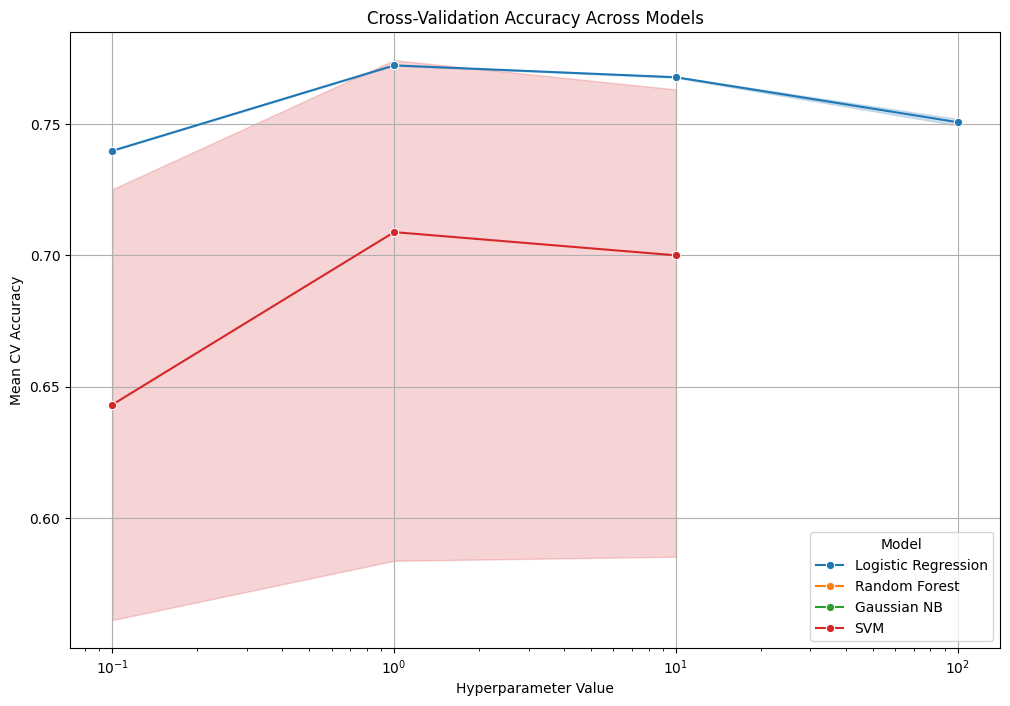

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the combined results
plt.figure(figsize=(12, 8))

# Use mean_test_score as the y-axis (accuracy), and param grid values for the x-axis
sns.lineplot(
    data=combined_results,
    x='param_C',  # Replace with appropriate parameter for comparison (e.g., param_C for LR/SVM, param_n_estimators for RF)
    y='mean_test_score',
    hue='Model',
    marker='o'
)

plt.xscale('log')  # Use log scale for parameters like C or smoothing
plt.title("Cross-Validation Accuracy Across Models")
plt.xlabel("Hyperparameter Value")
plt.ylabel("Mean CV Accuracy")
plt.legend(title="Model")
plt.grid()
plt.show()


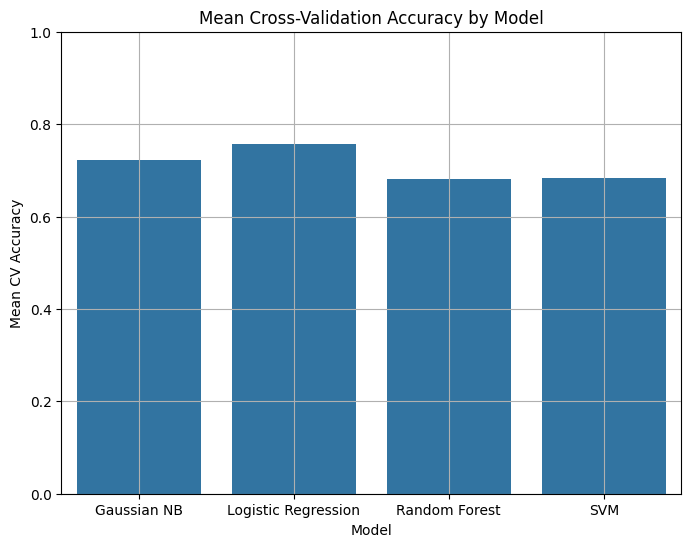

In [25]:
# Compute mean accuracy for each model
mean_accuracy = combined_results.groupby('Model')['mean_test_score'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=mean_accuracy, x='Model', y='mean_test_score')
plt.title("Mean Cross-Validation Accuracy by Model")
plt.xlabel("Model")
plt.ylabel("Mean CV Accuracy")
plt.ylim(0, 1)
plt.grid()
plt.show()


In [23]:
baseModelPath = 'models/'
baseTestPath = 'testData/'
modelExtension = '.joblib'
dataExtension = '.csv'

logisticRegressionModelPath = baseModelPath + 'logisticRegressionModel' + modelExtension
gaussianNBModelPath = baseModelPath + 'gaussianNBModel' + modelExtension
randomForestModelPath = baseModelPath + 'rfClassifierModel' + modelExtension
svmModelPath = baseModelPath + 'svmModel' + modelExtension
vectorizerPath = baseModelPath + 'vectorizer' + modelExtension

yTestPath = baseTestPath + "yTest" + dataExtension
logisticRegressionPredPath = baseTestPath + 'logisticRegressionPred' + dataExtension
gaussianNBPredPath = baseTestPath + 'gaussianNBPred' + dataExtension
randomForestPredPath = baseTestPath + 'rfClassifierPred' + dataExtension
svmPredPath = baseTestPath + 'svmPred' + dataExtension

dump(lr_model, logisticRegressionModelPath)
print(f"Saved LR Model to {logisticRegressionModelPath}")
dump(nb_model, gaussianNBModelPath)
print(f"Saved NB Model to {gaussianNBModelPath}")
dump(rf_model, randomForestModelPath)
print(f"Saved RF Model to {randomForestModelPath}")
dump(svm_model, svmModelPath)
print(f"Saved SVM Model to {svmModelPath}")
dump(tfidf_vectorizer, vectorizerPath)
print(f"Saved TF-IDF Vectorizer to {vectorizerPath}")

y_test.to_csv(yTestPath)
print(f"Saved ground-truth test values to {yTestPath}")
y_pred_lr.to_csv(logisticRegressionPredPath)
print(f"Saved logistic regression predictions to {logisticRegressionPredPath}")
y_pred_nb.to_csv(gaussianNBPredPath)
print(f"Saved Gaussian NB predictions to {gaussianNBPredPath}")
y_pred_rf.to_csv(randomForestPredPath)
print(f"Saved RF Classifier predictions to {randomForestPredPath}")
y_pred_svm.to_csv(svmPredPath)
print(f"Saved SVM predictions to {svmPredPath}")



models/logisticRegressionModel.joblib


In [ ]:
custom_model_path = 'models/logisticRegressionModel.joblib'
custom_vectorizer_path = 'models/vectorizer.joblib'

def predict_sarcasm(input_headline, model_path=custom_model_path, vectorizer_path=custom_vectorizer_path):
    # Load the trained model and vectorizer
    model = load(model_path)
    vectorizer = load(vectorizer_path)
    
    # Preprocess the input headline using the same function used for training data
    processed_headline = preprocess_headline(input_headline)
    
    # Transform the input headline using the loaded vectorizer
    X_input = vectorizer.transform([processed_headline])
    
    # Predict using the model
    prediction = model.predict(X_input)[0]
    
    # Convert the numeric prediction (0 or 1) into a more readable string
    if prediction == 1:
        return "This headline is likely sarcastic."
    else:
        return "This headline is likely not sarcastic."

In [ ]:
print(predict_sarcasm("This is the best news I've heard all year!"))

In [24]:
print(predict_sarcasm("Heroic man saved kitten from a tree"))

NameError: name 'predict_sarcasm' is not defined

In [ ]:
print(predict_sarcasm("This poltician is doing a tremendous job"))

In [ ]:
print(predict_sarcasm("This politician isn't exactly doing a top-notch job..."))